In [67]:
!rm -rf /kaggle/working/Output

In [ ]:
# pip install ultralytics

In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# # do not forgot to restart session 

In [ ]:
# import torch
# import torch
# import ultralytics
# from ultralytics.utils.torch_utils import select_device

# print(torch.cuda.is_available())  # Should return True
# print(torch.cuda.get_device_name(0))  # Should say Tesla T4
# print(f"Ultralytics YOLOv8 version: {ultralytics.__version__}")

# device = select_device('')
# print(f"YOLOv8 Selected Device: {device}")

# print(f"Ultralytics YOLOv8 version: {ultralytics.__version__}")
# print(f"PyTorch version: {torch.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")
# print(f"GPU Name: {torch.cuda.get_device_name(0)}")
# print(f"YOLOv8 Selected Device: {select_device('')}")

# print(torch.version.cuda)

## YOLO AND Sort

## Prepare the dataset for YOLOv8

In [ ]:
import os
import shutil
import yaml
from pathlib import Path
import numpy as np
from tqdm import tqdm
from PIL import Image

# Define the paths
DATASET_PATH = "/kaggle/input/cv-multiobject-dectection-dataset"
VISDRONE_MOT_TRAIN = os.path.join(DATASET_PATH, "VisDrone2019-MOT-train/VisDrone2019-MOT-train")
VISDRONE_MOT_VAL = os.path.join(DATASET_PATH, "VisDrone2019-MOT-val/VisDrone2019-MOT-val")
VISDRONE_MOT_TEST = os.path.join(DATASET_PATH, "VisDrone2019-MOT-test-challenge/VisDrone2019-MOT-test-challenge")
OUTPUT_PATH = "/kaggle/working/yolo_dataset"

# Create output directories
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "images", "val"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "images", "test"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "labels", "val"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "labels", "test"), exist_ok=True)

# VisDrone MOT categories
# The VisDrone annotation format appears to be:
# <frame_index>,<target_id>,<bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
#
# The object_category is defined as:
# 0: ignored regions
# 1: pedestrian
# 2: people
# 3: bicycle
# 4: car
# 5: van
# 6: truck
# 7: tricycle
# 8: awning-tricycle
# 9: bus
# 10: motor
# 11: others

# Define the class mapping - we'll map VisDrone classes to YOLOv8 format
# We'll skip class 0 (ignored regions) and class 11 (others)
class_mapping = {
    1: 0,  # pedestrian
    2: 1,  # people
    3: 2,  # bicycle
    4: 3,  # car
    5: 4,  # van
    6: 5,  # truck
    7: 6,  # tricycle
    8: 7,  # awning-tricycle
    9: 8,  # bus
    10: 9,  # motor
}

# Class names for YAML file
class_names = [
    'pedestrian',
    'people',
    'bicycle',
    'car',
    'van',
    'truck',
    'tricycle',
    'awning-tricycle',
    'bus',
    'motor'
]

def convert_annotation(annotation_file, sequence_folder, split_type):
    """
    Convert VisDrone annotation format to YOLO format
    """
    sequence_name = os.path.basename(sequence_folder)
    
    # Read the annotation file
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    
    # Group annotations by frame
    frame_annotations = {}
    for line in lines:
        line = line.strip().split(',')
        frame_idx = int(line[0])
        if frame_idx not in frame_annotations:
            frame_annotations[frame_idx] = []
        frame_annotations[frame_idx].append(line)
    
    # Process each frame
    for frame_idx, annotations in frame_annotations.items():
        # Source image path
        img_file = f"{frame_idx:07d}.jpg"
        img_path = os.path.join(sequence_folder, img_file)
        
        if not os.path.exists(img_path):
            continue
        
        # Destination paths
        dst_img_path = os.path.join(OUTPUT_PATH, "images", split_type, f"{sequence_name}_{img_file}")
        dst_label_path = os.path.join(OUTPUT_PATH, "labels", split_type, f"{sequence_name}_{img_file.replace('.jpg', '.txt')}")
        
        # Copy the image
        shutil.copy(img_path, dst_img_path)
        
        # Convert annotations to YOLO format and write to file
        with open(dst_label_path, 'w') as f:
            # Get image dimensions
            # We'll use PIL to get the image dimensions
            from PIL import Image
            img = Image.open(img_path)
            img_width, img_height = img.size
            
            for anno in annotations:
                obj_id = int(anno[1])
                bbox_left = float(anno[2])
                bbox_top = float(anno[3])
                bbox_width = float(anno[4])
                bbox_height = float(anno[5])
                obj_class = int(anno[7])
                
                # Skip ignored regions and others
                if obj_class == 0 or obj_class == 11:
                    continue
                
                # Map to YOLO class
                if obj_class not in class_mapping:
                    continue
                yolo_class = class_mapping[obj_class]
                
                # Convert bbox to YOLO format (x_center, y_center, width, height) - normalized
                x_center = (bbox_left + bbox_width / 2) / img_width
                y_center = (bbox_top + bbox_height / 2) / img_height
                width = bbox_width / img_width
                height = bbox_height / img_height
                
                # Write to file
                f.write(f"{yolo_class} {x_center} {y_center} {width} {height}\n")

def process_dataset():
    """
    Process the dataset using the existing train/val/test splits
    """
    # Process training data
    train_sequences_folder = os.path.join(VISDRONE_MOT_TRAIN, "sequences")
    train_annotations_folder = os.path.join(VISDRONE_MOT_TRAIN, "annotations")
    
    train_sequences = [f for f in os.listdir(train_sequences_folder) if os.path.isdir(os.path.join(train_sequences_folder, f))]
    
    for seq in tqdm(train_sequences, desc="Processing train set"):
        seq_path = os.path.join(train_sequences_folder, seq)
        anno_path = os.path.join(train_annotations_folder, f"{seq}.txt")
        if os.path.exists(anno_path):
            convert_annotation(anno_path, seq_path, "train")
    
    # Process validation data
    val_sequences_folder = os.path.join(VISDRONE_MOT_VAL, "sequences")
    val_annotations_folder = os.path.join(VISDRONE_MOT_VAL, "annotations")
    
    val_sequences = [f for f in os.listdir(val_sequences_folder) if os.path.isdir(os.path.join(val_sequences_folder, f))]
    
    for seq in tqdm(val_sequences, desc="Processing validation set"):
        seq_path = os.path.join(val_sequences_folder, seq)
        anno_path = os.path.join(val_annotations_folder, f"{seq}.txt")
        if os.path.exists(anno_path):
            convert_annotation(anno_path, seq_path, "val")
    
    # Process test data
    test_sequences_folder = os.path.join(VISDRONE_MOT_TEST, "sequences")
    test_annotations_folder = os.path.join(VISDRONE_MOT_TEST, "annotations")
    
    test_sequences = [f for f in os.listdir(test_sequences_folder) if os.path.isdir(os.path.join(test_sequences_folder, f))]
    
    for seq in tqdm(test_sequences, desc="Processing test set"):
        seq_path = os.path.join(test_sequences_folder, seq)
        # For test-challenge, we might not have annotations
        anno_path = os.path.join(test_annotations_folder, f"{seq}.txt")
        if os.path.exists(anno_path):
            convert_annotation(anno_path, seq_path, "test")
        else:
            # If no annotations, just copy images
            for img_file in os.listdir(seq_path):
                if img_file.endswith('.jpg'):
                    src_img_path = os.path.join(seq_path, img_file)
                    dst_img_path = os.path.join(OUTPUT_PATH, "images", "test", f"{seq}_{img_file}")
                    shutil.copy(src_img_path, dst_img_path)

def create_yaml_file():
    """
    Create YAML configuration file for YOLOv8
    """
    yaml_content = {
        'path': OUTPUT_PATH,
        'train': os.path.join('images', 'train'),
        'val': os.path.join('images', 'val'),
        'test': os.path.join('images', 'test'),
        'nc': len(class_names),  # number of classes
        'names': class_names
    }
    
    with open(os.path.join(OUTPUT_PATH, 'visdrone.yaml'), 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)

if __name__ == "__main__":
    print("Starting dataset preparation...")
    process_dataset()
    create_yaml_file()
    
    # Print some statistics
    train_images = len(os.listdir(os.path.join(OUTPUT_PATH, "images", "train")))
    val_images = len(os.listdir(os.path.join(OUTPUT_PATH, "images", "val")))
    test_images = len(os.listdir(os.path.join(OUTPUT_PATH, "images", "test")))
    
    print(f"Dataset preparation complete!")
    print(f"Train images: {train_images}")
    print(f"Validation images: {val_images}")
    print(f"Test images: {test_images}")
    print(f"YAML configuration file created at: {os.path.join(OUTPUT_PATH, 'visdrone.yaml')}")

## Configure YOLOv8 model

In [ ]:
import yaml
from ultralytics import YOLO
import os

# Set the paths
OUTPUT_PATH = "/kaggle/working/yolo_dataset"
MODELS_PATH = "/kaggle/working/models"
YAML_PATH = os.path.join(OUTPUT_PATH, "visdrone.yaml")

# Create models directory if it doesn't exist
os.makedirs(MODELS_PATH, exist_ok=True)

def select_model_size():
    """
    Select the appropriate model size based on your requirements
    - nano: Fastest but least accurate (ideal for resource-constrained environments)
    - small: Good balance between speed and accuracy
    - medium: More accurate but slower than small
    - large: Most accurate but slowest
    """
    model_sizes = {
        'n': 'yolov8n',  # Nano
        's': 'yolov8s',  # Small
        'm': 'yolov8m',  # Medium
        'l': 'yolov8l',  # Large
        'x': 'yolov8x'   # Extra Large
    }
    
    print("Select YOLOv8 model size:")
    print("n - Nano (fastest, least accurate)")
    print("s - Small (good balance)")
    print("m - Medium (more accurate, slower)")
    print("l - Large (most accurate, slowest)")
    print("x - Extra Large (highest accuracy, very slow)")
    
    choice = input("Enter your choice (default: s): ").lower() or 's'
    if choice not in model_sizes:
        print(f"Invalid choice: {choice}. Using Small model.")
        choice = 's'
    
    model_name = model_sizes[choice]
    print(f"Selected model: {model_name}")
    return model_name

def load_config():
    """Load the dataset configuration from YAML file"""
    with open(YAML_PATH, 'r') as f:
        config = yaml.safe_load(f)
    return config

def configure_model(model_size):
    """Configure the YOLOv8 model with the selected size"""

    model_path = os.path.join(MODELS_PATH, f"{model_size}.pt")
    
    # Check if the model file exists, otherwise download it
    if not os.path.exists(model_path):
        print(f"{model_size}.pt not found. Downloading it now...")
        model = YOLO(model_size)  # This will automatically download the model
        model.export(format="torch")  # Save it in the correct format
        os.rename(f"{model_size}.pt", model_path)  # Move to desired location
        print(f"Model downloaded and saved at {model_path}")
    else:
        print(f"Model found at {model_path}")

    # Load the pre-trained model
    model = YOLO(model_path)
    
    # Model configuration
    model_config = {
        'task': 'detect',
        'model': model_size,
        'data': YAML_PATH,
        'epochs': 10,
        'patience': 10,
        'batch': 16,
        'imgsz': 640,
        'device': 0,  # Use GPU if available
        'workers': 8,
        'project': MODELS_PATH,
        'name': f'visdrone_{model_size.lower()}',
    }
    
    # Save the configuration
    config_path = os.path.join(MODELS_PATH, f"{model_size.lower()}_config.yaml")
    with open(config_path, 'w') as f:
        yaml.dump(model_config, f)
    
    print(f"Model configuration saved to {config_path}")
    return model_config

def main():
    """Main function to configure the YOLOv8 model"""
    dataset_config = load_config()
    print(f"Dataset configuration loaded from {YAML_PATH}")
    print(f"Number of classes: {dataset_config['nc']}")
    print(f"Classes: {dataset_config['names']}")
    
    model_size = select_model_size()
    model_config = configure_model(model_size)
    
    print("\nModel configuration complete!")
    print("Next steps:")
    print("Run the training script")
    print("Monitor training metrics")
    print("Evaluate model performance")
    
    return model_config

if __name__ == "__main__":
    model_config = main()

## Train the model

In [ ]:
# Train YOLOv8 Model
import os
import yaml
import torch
from ultralytics import YOLO
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set the paths
MODELS_PATH = "/kaggle/working/models"
OUTPUT_PATH = "/kaggle/working/yolo_dataset"
YAML_PATH = os.path.join(OUTPUT_PATH, "visdrone.yaml")

def load_model_config(config_path=None):
    """Load model configuration from file or use default"""
    if config_path and os.path.exists(config_path):
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        return config
    
    # Default configuration if no file is provided
    config_files = [f for f in os.listdir(MODELS_PATH) if f.endswith('_config.yaml')]
    if config_files:
        config_path = os.path.join(MODELS_PATH, config_files[0])
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        return config
    
    # Fallback to very basic configuration
    return {
        'task': 'detect',
        'model': 'YOLOv8s.pt',
        'data': YAML_PATH,
        'epochs': 10,
        'patience': 10,
        'batch': 16,
        'imgsz': 640,
        'device': 0,
        'workers': 8,
        'project': MODELS_PATH,
        'name': 'visdrone_default',
    }

def check_gpu_availability():
    """Check if GPU is available and print info"""
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        print(f"GPU available! Found {device_count} GPU(s).")
        for i in range(device_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Current GPU: {torch.cuda.current_device()}")
        print(f"Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"Memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    else:
        print("No GPU available. Training will be slow on CPU.")

def custom_hyperparameters():
    """Customize hyperparameters for training"""
    hyperparams = {}
    
    # Learning rate
    hyperparams['lr0'] = 0.01  # Initial learning rate
    hyperparams['lrf'] = 0.01  # Final learning rate ratio

    # Optimizer parameters
    hyperparams['momentum'] = 0.937
    hyperparams['weight_decay'] = 0.0005
    
    # Augmentation parameters
    hyperparams['hsv_h'] = 0.015  # HSV-Hue augmentation
    hyperparams['hsv_s'] = 0.7    # HSV-Saturation augmentation
    hyperparams['hsv_v'] = 0.4    # HSV-Value augmentation
    hyperparams['degrees'] = 0.0   # Rotation augmentation
    hyperparams['translate'] = 0.1  # Translation augmentation
    hyperparams['scale'] = 0.5     # Scale augmentation
    hyperparams['fliplr'] = 0.5    # Horizontal flip augmentation
    hyperparams['mosaic'] = 1.0    # Mosaic augmentation
    
    return hyperparams

def train_model(config, hyperparams=None):
    """Train the YOLOv8 model with the given configuration"""

    # Ensure we train for only 10 epochs
    config['epochs'] = 10  

    # Explicitly set device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load model
    model = YOLO(config['model'])

    # Train the model
    results = model.train(
        data=config['data'],
        epochs=config['epochs'],
        patience=config['patience'],
        batch=config['batch'],
        imgsz=config['imgsz'],
        device=device,  # Ensure GPU is used
        workers=config['workers'],
        project=config['project'],
        name=config['name'],
        exist_ok=True,
        pretrained=True,
        **(hyperparams or {})
    )
    
    return model, results


def plot_training_results(results_file):
    """Plot training metrics from results CSV"""
    if not os.path.exists(results_file):
        print(f"Results file not found: {results_file}")
        return
    
    # Load results
    results = pd.read_csv(results_file)
    
    # Plot metrics
    metrics = ['box_loss', 'cls_loss', 'dfl_loss', 'precision', 'recall', 'mAP50', 'mAP50-95']
    
    plt.figure(figsize=(20, 14))
    
    for i, metric in enumerate(metrics):
        if metric in results.columns:
            plt.subplot(3, 3, i+1)
            plt.plot(results['epoch'], results[metric], 'b-')
            plt.title(f'Training {metric}')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_PATH, 'training_metrics.png'))
    plt.show()

def main():
    """Main function to train the YOLOv8 model"""
    # Check GPU availability
    check_gpu_availability()
    
    # Load model configuration
    config_files = [f for f in os.listdir(MODELS_PATH) if f.endswith('_config.yaml')]
    if config_files:
        config_path = os.path.join(MODELS_PATH, config_files[0])
        print(f"Loading configuration from {config_path}")
        config = load_model_config(config_path)
    else:
        print("No configuration file found. Using default configuration.")
        config = load_model_config()
    
    # Customize hyperparameters
    hyperparams = custom_hyperparameters()
    
    # Train the model
    model, results = train_model(config, hyperparams)
    
    # Plot training results
    results_file = os.path.join(MODELS_PATH, config['name'], 'results.csv')
    plot_training_results(results_file)
    
    print("\nTraining complete!")
    print(f"Model saved at: {os.path.join(MODELS_PATH, config['name'])}")
    print("Next steps:")
    print("1. Evaluate model performance")
    print("2. Run inference on test images")
    print("3. Export model for deployment")
    
    return model

if __name__ == "__main__":
    model = main()

## Detection

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load your trained model
model_path = "/kaggle/working/models/visdrone_yolov8s/weights/best.pt"
model = YOLO(model_path)

# Path to the test image
image_path = "/kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-train/VisDrone2019-MOT-train/sequences/uav0000013_00000_v/0000001.jpg"

# Run inference on the image
results = model.predict(image_path, conf=0.25)

# Plot the results
plt.figure(figsize=(12, 10))
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result_img = results[0].plot()
plt.imshow(result_img)
plt.axis('off')
plt.title("Prediction Results")
plt.show()

# Print detection statistics
print(f"Number of detections: {len(results[0].boxes)}")
print(f"Detected classes: {results[0].names}")

# Print detailed results for top 5 detections
for i, box in enumerate(results[0].boxes[:5]):
    class_id = int(box.cls)
    confidence = float(box.conf)
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    print(f"Detection {i+1}: Class: {results[0].names[class_id]}, Confidence: {confidence:.2f}, Coordinates: [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")

In [ ]:
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image

# Path to the folder containing images
image_folder = "/kaggle/working/yolo_dataset/inference_results/"

# Get all image file paths
image_paths = sorted(glob(os.path.join(image_folder, "*.jpg")))  # Change "*.jpg" if images have a different extension

# Plot images
plt.figure(figsize=(15, 15))
columns = 4
rows = (len(image_paths) + columns - 1) // columns  # Calculate number of rows dynamically

for i, image_path in enumerate(image_paths, 1):
    img = Image.open(image_path)
    plt.subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(image_path))

plt.tight_layout()
plt.show()

## Sort

In [ ]:
pip install torch opencv-python numpy tqdm supervision

In [ ]:
pip install lap

In [ ]:
import os
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from tqdm import tqdm
import lap  # Linear assignment problem solver

class KalmanFilter:
    """Simple Kalman Filter implementation for tracking"""
    def __init__(self):
        # State transition matrix
        self.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                           [0, 1, 0, 0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0, 0, 1, 0],
                           [0, 0, 0, 1, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1, 0, 0, 0],
                           [0, 0, 0, 0, 0, 1, 0, 0],
                           [0, 0, 0, 0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 0, 0, 0, 1]])
        
        # Measurement matrix
        self.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                           [0, 1, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0],
                           [0, 0, 0, 1, 0, 0, 0, 0]])
        
        # Measurement noise
        self.R = np.eye(4) * 0.1
        
        # Process noise
        self.Q = np.eye(8) * 0.1
        self.Q[4:, 4:] *= 10
        
        # Error covariance
        self.P = np.eye(8) * 10
        
        # State
        self.x = np.zeros((8, 1))
        
    def predict(self):
        """Predict next state"""
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x[:4].flatten()
        
    def update(self, z):
        """Update state with measurement z"""
        z = z.reshape(-1, 1)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(8)
        self.P = (I - K @ self.H) @ self.P
        return self.x[:4].flatten()
        
    def initiate(self, measurement):
        """Initialize state with first measurement"""
        self.x = np.zeros((8, 1))
        self.x[:4, 0] = measurement
        return self.x[:4].flatten()


class Track:
    """Track class for DeepSORT"""
    count = 0
    
    def __init__(self, detection, class_id):
        self.id = Track.count
        Track.count += 1
        
        self.class_id = class_id
        self.hits = 1
        self.age = 1
        self.time_since_update = 0
        
        # Initialize Kalman filter
        self.kf = KalmanFilter()
        
        # Initialize state
        box = detection[:4]
        self.mean = self.kf.initiate(box)
        
        # Detection confidence
        self.confidence = detection[4] if len(detection) > 4 else 1.0
        
    def predict(self):
        """Predict next state"""
        self.mean = self.kf.predict()
        self.age += 1
        self.time_since_update += 1
        return self.mean
        
    def update(self, detection):
        """Update track with new detection"""
        box = detection[:4]
        self.mean = self.kf.update(box)
        self.hits += 1
        self.time_since_update = 0
        
        # Update confidence
        if len(detection) > 4:
            self.confidence = detection[4]
        
        # Update class_id if provided
        if len(detection) > 5:
            self.class_id = detection[5]
        
        return self.mean
        
    def get_state(self):
        """Get current state"""
        return self.mean
    
    def is_confirmed(self):
        """Check if track is confirmed"""
        return self.hits >= 3
    
    def is_deleted(self):
        """Check if track should be deleted"""
        return self.time_since_update > 30


class SimpleTracker:
    """Simple implementation of DeepSORT tracker"""
    def __init__(self):
        self.tracks = []
        self.max_iou_distance = 0.7
        self.max_age = 30
        self.min_hits = 3
        
    def update(self, detections):
        """Update tracks with new detections"""
        # Predict locations of existing tracks
        for track in self.tracks:
            track.predict()
        
        # Match detections to tracks
        matches, unmatched_tracks, unmatched_detections = self._match(detections)
        
        # Update matched tracks
        for track_idx, detection_idx in matches:
            self.tracks[track_idx].update(detections[detection_idx])
        
        # Mark unmatched tracks
        for track_idx in unmatched_tracks:
            self.tracks[track_idx].time_since_update += 1
        
        # Add new tracks
        for detection_idx in unmatched_detections:
            detection = detections[detection_idx]
            class_id = int(detection[5]) if len(detection) > 5 else -1
            self.tracks.append(Track(detection, class_id))
        
        # Remove dead tracks
        self.tracks = [t for t in self.tracks if not t.is_deleted()]
        
        # Get results
        results = []
        for track in self.tracks:
            if track.is_confirmed():
                box = track.get_state()
                results.append(np.append(box, [track.id, track.class_id, track.confidence]))
        
        return np.array(results) if results else np.empty((0, 7))
    
    def _match(self, detections):
        """Match detections to tracks using IoU"""
        if len(self.tracks) == 0 or len(detections) == 0:
            return [], list(range(len(self.tracks))), list(range(len(detections)))
        
        # Compute IoU matrix
        iou_matrix = np.zeros((len(self.tracks), len(detections)))
        for i, track in enumerate(self.tracks):
            for j, detection in enumerate(detections):
                iou_matrix[i, j] = self._iou(track.get_state(), detection[:4])
        
        # Convert to cost matrix
        cost_matrix = 1 - iou_matrix
        
        # Solve linear assignment problem
        row_indices, col_indices = lap.lapjv(cost_matrix, extend_cost=True)[0:2]
        
        # Filter matches
        matches = []
        unmatched_tracks = []
        unmatched_detections = []
        
        for track_idx, detection_idx in enumerate(col_indices):
            if detection_idx >= 0:
                if cost_matrix[track_idx, detection_idx] > self.max_iou_distance:
                    unmatched_tracks.append(track_idx)
                    unmatched_detections.append(detection_idx)
                else:
                    matches.append((track_idx, detection_idx))
            else:
                unmatched_tracks.append(track_idx)
        
        # Add unmatched detections
        for detection_idx in range(len(detections)):
            if detection_idx not in col_indices:
                unmatched_detections.append(detection_idx)
        
        return matches, unmatched_tracks, unmatched_detections
    
    def _iou(self, box1, box2):
        """Calculate IoU between two boxes"""
        # Convert to [x1, y1, x2, y2] if necessary
        box1 = np.array(box1).reshape(-1)
        box2 = np.array(box2).reshape(-1)
        
        # Calculate intersection area
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        
        # Calculate union area
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        
        union = area1 + area2 - intersection
        
        # Calculate IoU
        return intersection / union if union > 0 else 0


class ObjectTracker:
    """Object tracker using YOLOv8 and Simple DeepSORT"""
    def __init__(self, model_path):
        """Initialize tracker with YOLOv8 model"""
        # Load YOLOv8 model
        self.model = YOLO(model_path)
        
        # Initialize tracker
        self.tracker = SimpleTracker()
        
        # Class names for VisDrone dataset
        self.class_names = ['pedestrian', 'people', 'bicycle', 'car', 'van', 
                           'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor']
        
        # Dictionary to store trajectory points for each object
        self.trajectories = {}
        
        # Dictionary to store unique colors for each track ID
        self.track_colors = {}
    
    def _get_color_for_track(self, track_id):
        """Get a unique color for a track ID"""
        if track_id not in self.track_colors:
            # Generate a random color that's not too dark
            color = np.random.randint(80, 255, size=3).tolist()
            self.track_colors[track_id] = color
        return self.track_colors[track_id]
    
    def process_sequence(self, sequence_path, output_path, conf_threshold=0.3):
        """Process image sequence and create tracking video"""
        # Get all image files
        image_files = sorted([f for f in os.listdir(sequence_path) 
                             if f.endswith(('.jpg', '.png', '.jpeg'))])
        
        if not image_files:
            print(f"No images found in {sequence_path}")
            return
        
        # Read first image to get dimensions
        first_image = cv2.imread(os.path.join(sequence_path, image_files[0]))
        height, width = first_image.shape[:2]
        
        # Create output directory
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Initialize video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, 30, (width, height))
        
        # Process each frame
        for img_file in tqdm(image_files, desc="Processing frames"):
            # Read image
            img_path = os.path.join(sequence_path, img_file)
            frame = cv2.imread(img_path)
            if frame is None:
                continue
            
            # Run YOLOv8 detection
            results = self.model(frame, conf=conf_threshold, verbose=False)
            
            # Prepare detections for tracker
            detections = []
            if results[0].boxes.data.shape[0] > 0:
                # Get detection data: [x1, y1, x2, y2, conf, class_id]
                boxes = results[0].boxes.data.cpu().numpy()
                
                # Format detections for tracker
                for box in boxes:
                    x1, y1, x2, y2 = box[:4]
                    conf = box[4]
                    class_id = int(box[5]) if len(box) > 5 else 0
                    detections.append([x1, y1, x2, y2, conf, class_id])
            
            # Update tracker
            if detections:
                tracks = self.tracker.update(np.array(detections))
                
                # First draw trajectories
                for track in tracks:
                    # Extract tracking info
                    x1, y1, x2, y2, track_id, class_id, conf = track
                    
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    track_id = int(track_id)
                    
                    # Calculate center point of bounding box
                    center_x = int((x1 + x2) / 2)
                    center_y = int((y1 + y2) / 2)
                    
                    # Get unique color for this track ID
                    color = self._get_color_for_track(track_id)
                    
                    # Add center point to trajectory
                    if track_id not in self.trajectories:
                        self.trajectories[track_id] = []
                    self.trajectories[track_id].append((center_x, center_y))
                    
                    # Draw trajectory line
                    if len(self.trajectories[track_id]) > 1:
                        points = np.array(self.trajectories[track_id], np.int32)
                        cv2.polylines(frame, [points], False, color, 2)
                
                # Then draw bounding boxes (so they're on top of lines)
                for track in tracks:
                    # Extract tracking info
                    x1, y1, x2, y2, track_id, class_id, conf = track
                    
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    class_id = int(class_id)
                    track_id = int(track_id)
                    
                    # Get unique color for this track ID
                    color = self._get_color_for_track(track_id)
                    
                    # Get class name
                    class_name = self.class_names[class_id] if class_id < len(self.class_names) else 'unknown'
                    
                    # Draw bounding box
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                    
                    # # Draw class name and track ID
                    # label = f"{class_name}-{track_id}"
                    # t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
                    # cv2.rectangle(frame, (x1, y1-t_size[1]-10), (x1+t_size[0], y1), color, -1)
                    # cv2.putText(frame, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            
            # Write frame to output video
            out.write(frame)
            
            # Optional: Save each processed frame as an image
            output_img_dir = os.path.join(os.path.dirname(output_path), "processed_frames")
            os.makedirs(output_img_dir, exist_ok=True)
            cv2.imwrite(os.path.join(output_img_dir, img_file), frame)
        
        # Release video writer
        out.release()
        print(f"Output saved to {output_path}")
        print(f"Processed frames saved to {output_img_dir}")
        
        # Return output path
        return output_path

    def clear_trajectories(self):
        """Clear all tracked trajectories"""
        self.trajectories = {}
        self.track_colors = {}


# Function to process a test sequence
def process_test_sequence(model_path, sequence_path):
    """Process a test sequence with tracking"""
    # Initialize tracker
    tracker = ObjectTracker(model_path)
    
    # Output path
    os.makedirs("tracking_results", exist_ok=True)
    sequence_name = os.path.basename(sequence_path)
    output_path = f"tracking_results/{sequence_name}_tracked_shot.mp4"
    
    # Process sequence
    result_path = tracker.process_sequence(sequence_path, output_path)
    
    print(f"Tracking completed! Video saved to: {result_path}")
    return result_path


# Main function
def main():
    # Path to your YOLOv8 model
    model_path = "yolov8n.pt"  # Update this with your model path
    
    # Direct path to the sequence folder
    sequence_path = "/kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-test-dev/VisDrone2019-MOT-test-dev/sequences/uav0000009_03358_v/"
    
    # Process the sequence
    result_path = process_test_sequence(model_path, sequence_path)
    
    # Display information about the result
    print(f"Tracking results saved to: {result_path}")


if __name__ == "__main__":
    main()

## ResNet50 as a feature extractor for ReID

In [69]:
import os
from glob import glob

class VisDroneDataset:
    def __init__(self, train_path, val_path, test_path):
        """
        Initialize the VisDrone dataset handler with the paths for train, val, and test
        Args:
            train_path: Path to the train dataset
            val_path: Path to the val dataset
            test_path: Path to the test dataset
        """
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        
    def list_sequences(self, split_path):
        """
        List all sequences in a specific split
        Args:
            split_path: Path to the sequences directory (train, val, or test)
        Returns:
            List of sequence directories
        """
        seq_path = os.path.join(split_path, 'sequences')
        return sorted(glob(os.path.join(seq_path, '*')))
    
    def get_annotation_path(self, split_path, sequence_name):
        """
        Get the path to annotations for a specific sequence
        Args:
            split_path: Path to the annotations directory (train, val, or test)
            sequence_name: Name of the sequence (e.g., 'uav0000013_00000_v')
        Returns:
            Path to the annotation file
        """
        return os.path.join(split_path, 'annotations', f"{sequence_name}.txt")
    
    def get_frames_path(self, split_path, sequence_name):
        """
        Get path to all frames for a specific sequence
        Args:
            split_path: Path to the sequences directory (train, val, or test)
            sequence_name: Name of the sequence (e.g., 'uav0000013_00000_v')
        Returns:
            Path to the sequence frames directory
        """
        return os.path.join(split_path, 'sequences', sequence_name)


# Example usage
dataset = VisDroneDataset(
    train_path='/kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-train/VisDrone2019-MOT-train',
    val_path='/kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-val/VisDrone2019-MOT-val',
    test_path='/kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-test-dev/VisDrone2019-MOT-test-dev'
)

# Get sequences for train, val, or test
train_sequences = dataset.list_sequences(dataset.train_path)
print(f"Found {len(train_sequences)} training sequences")

if len(train_sequences) > 0:
    first_sequence = os.path.basename(train_sequences[0])
    print(f"First sequence: {first_sequence}")
    
    frames_path = dataset.get_frames_path(dataset.train_path, first_sequence)
    print(f"Frames path: {frames_path}")
    
    annotation_path = dataset.get_annotation_path(dataset.train_path, first_sequence)
    print(f"Annotation path: {annotation_path}")

Found 56 training sequences
First sequence: uav0000013_00000_v
Frames path: /kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-train/VisDrone2019-MOT-train/sequences/uav0000013_00000_v
Annotation path: /kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-train/VisDrone2019-MOT-train/annotations/uav0000013_00000_v.txt


In [70]:
class AnnotationParser:
    """
    Parse VisDrone MOT annotation format
    Format: <frame_index>,<target_id>,<bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
    """
    def __init__(self, annotation_file):
        self.annotation_file = annotation_file
        self.annotations = self._load_annotations()
        
    def _load_annotations(self):
        """Load annotations from file and organize by frame"""
        annotations_by_frame = {}
        
        try:
            with open(self.annotation_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) < 10:  # Basic validation
                        continue
                        
                    frame_idx = int(parts[0])
                    target_id = int(parts[1])
                    bbox_left = int(float(parts[2]))
                    bbox_top = int(float(parts[3]))
                    bbox_width = int(float(parts[4]))
                    bbox_height = int(float(parts[5]))
                    score = float(parts[6])
                    category = int(parts[7])
                    truncation = int(parts[8])
                    occlusion = int(parts[9])
                    
                    if frame_idx not in annotations_by_frame:
                        annotations_by_frame[frame_idx] = []
                        
                    annotations_by_frame[frame_idx].append({
                        'target_id': target_id,
                        'bbox': [bbox_left, bbox_top, bbox_width, bbox_height],
                        'score': score,
                        'category': category,
                        'truncation': truncation,
                        'occlusion': occlusion
                    })
            
            return annotations_by_frame
        except FileNotFoundError:
            print(f"Warning: Annotation file {self.annotation_file} not found")
            return {}
    
    def get_frame_annotations(self, frame_idx):
        """Get all annotations for a specific frame"""
        return self.annotations.get(frame_idx, [])
    
    def get_all_targets(self):
        """Get a set of all unique target IDs in the annotation file"""
        targets = set()
        for frame_idx, annotations in self.annotations.items():
            for ann in annotations:
                targets.add(ann['target_id'])
        return targets
    
    def get_target_trajectory(self, target_id):
        """Get the trajectory (bboxes) for a specific target across all frames"""
        trajectory = {}
        for frame_idx, annotations in self.annotations.items():
            for ann in annotations:
                if ann['target_id'] == target_id:
                    trajectory[frame_idx] = ann['bbox']
        return trajectory

# Test the annotation parser
if len(train_sequences) > 0:
    sequence_name = os.path.basename(train_sequences[0])
    annotation_path = dataset.get_annotation_path(dataset.train_path, sequence_name)
    parser = AnnotationParser(annotation_path)
    print(f"Number of frames with annotations: {len(parser.annotations)}")
    print(f"Number of unique targets: {len(parser.get_all_targets())}")
    
    # Display annotations for first frame if available
    first_frame = min(parser.annotations.keys()) if parser.annotations else None
    if first_frame is not None:
        print(f"Annotations for frame {first_frame}:")
        for ann in parser.get_frame_annotations(first_frame)[:5]:  # Show first 5 annotations
            print(f"  Target {ann['target_id']}: bbox={ann['bbox']}, category={ann['category']}")

Number of frames with annotations: 269
Number of unique targets: 60
Annotations for frame 1:
  Target 0: bbox=[593, 43, 174, 190], category=0
  Target 1: bbox=[489, 307, 41, 62], category=0
  Target 2: bbox=[424, 543, 35, 88], category=1
  Target 3: bbox=[416, 530, 36, 85], category=1
  Target 4: bbox=[531, 641, 87, 114], category=7


In [71]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torch.nn import functional as F

class ReIDFeatureExtractor:
    """ReID feature extractor using ResNet50"""
    def __init__(self, use_gpu=True):
        self.device = torch.device('cuda') if use_gpu and torch.cuda.is_available() else torch.device('cpu')
        
        # Initialize ResNet50 model
        self.model = models.resnet50(pretrained=True)
        # Replace the final classifier layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 256)  # Reduce to 256 feature dimensions
        self.model.to(self.device)
        self.model.eval()  # Set to evaluation mode
        
        # Define image transforms
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize((256, 128)),  # Standard size for person ReID
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def extract_features(self, image_patches):
        """
        Extract features from image patches
        Args:
            image_patches: List of cropped image patches (numpy arrays)
        Returns:
            Tensor of features (N x 256)
        """
        if not image_patches:
            return None
            
        # Apply transforms to all patches
        batch = torch.stack([self.transform(patch) for patch in image_patches])
        batch = batch.to(self.device)
        
        # Extract features
        with torch.no_grad():
            features = self.model(batch)
            # L2 normalize features
            features = F.normalize(features, p=2, dim=1)
            
        return features.cpu()
    
    def compute_distance(self, feature1, feature2):
        """
        Compute distance between two feature vectors using cosine similarity
        Args:
            feature1, feature2: Feature vectors (torch tensors of any dimension)
        Returns:
            Distance score (lower means more similar)
        """
        # Flatten and normalize both features if needed
        if feature1.dim() > 1:
            feature1 = feature1.view(-1)
        if feature2.dim() > 1:
            feature2 = feature2.view(-1)
            
        # Normalize
        feature1 = F.normalize(feature1, p=2, dim=0)
        feature2 = F.normalize(feature2, p=2, dim=0)
        
        # Compute cosine similarity directly using dot product of normalized vectors
        similarity = torch.dot(feature1, feature2).item()
        
        # Convert to distance (0-2 range, where 0 means identical)
        distance = 1 - similarity
        return distance

# Function to extract patches from frames based on detections
def extract_patches(frame, detections):
    """
    Extract image patches from a frame based on detection bounding boxes
    Args:
        frame: OpenCV image
        detections: List of detection dictionaries with 'bbox' key
    Returns:
        List of cropped patches and corresponding detection indices
    """
    patches = []
    indices = []
    
    for i, det in enumerate(detections):
        bbox = det['bbox']  # [left, top, width, height]
        
        # Handle out-of-bounds coordinates
        x1 = max(0, bbox[0])
        y1 = max(0, bbox[1])
        x2 = min(frame.shape[1], bbox[0] + bbox[2])
        y2 = min(frame.shape[0], bbox[1] + bbox[3])
        
        # Skip if bbox is invalid
        if x2 <= x1 or y2 <= y1:
            continue
            
        patch = frame[y1:y2, x1:x2]
        
        # Skip very small patches
        if patch.shape[0] < 10 or patch.shape[1] < 10:
            continue
            
        patches.append(patch)
        indices.append(i)
    
    return patches, indices

In [72]:
class ReIDTracker:
    """
    A simple ReID-based tracker that uses feature similarity
    """
    def __init__(self, reid_model, distance_threshold=0.5, max_age=30):
        self.reid_model = reid_model
        self.distance_threshold = distance_threshold  # Max distance for association
        self.max_age = max_age  # Max frames to keep a track without matching
        self.tracks = {}  # Dictionary of track_id -> track info
        self.next_id = 1  # Next available track ID
        
    def update(self, frame, detections):
        """
        Update tracker with new detections
        Args:
            frame: Current frame (OpenCV image)
            detections: List of detection dictionaries with 'bbox' key
        Returns:
            Updated list of detections with 'target_id' key
        """
        # Extract patches and features for current detections
        patches, valid_indices = extract_patches(frame, detections)
        
        if not patches:
            # Increment age of all tracks since no detections were matched
            for track_id in self.tracks:
                self.tracks[track_id]['age'] += 1
                
            # Remove old tracks
            self.tracks = {k: v for k, v in self.tracks.items() if v['age'] <= self.max_age}
            return detections  # Return original detections (empty or invalid)
        
        # Extract features
        features = self.reid_model.extract_features(patches)
        
        # Match detections to existing tracks
        matched_track_indices = []
        matched_detection_indices = []
        
        # For each detection
        for i, det_idx in enumerate(valid_indices):
            det_feature = features[i].unsqueeze(0)
            best_track_id = None
            best_distance = float('inf')
            
            # Find best matching track
            for track_id, track_info in self.tracks.items():
                if track_id in matched_track_indices:
                    continue  # Skip already matched tracks
                    
                # Calculate distance between current detection and track
                distance = self.reid_model.compute_distance(det_feature, track_info['feature'])
                
                if distance < best_distance and distance < self.distance_threshold:
                    best_distance = distance
                    best_track_id = track_id
            
            if best_track_id is not None:
                # Match found, update track
                matched_track_indices.append(best_track_id)
                matched_detection_indices.append(det_idx)
                
                # Update track information
                self.tracks[best_track_id]['bbox'] = detections[det_idx]['bbox']
                # Feature evolution: update feature by weighted average of old and new
                alpha = 0.9  # Weight for historical feature (controls feature evolution rate)
                updated_feature = alpha * self.tracks[best_track_id]['feature'] + (1 - alpha) * det_feature
                updated_feature = F.normalize(updated_feature, p=2, dim=1)  # Re-normalize
                
                self.tracks[best_track_id]['feature'] = updated_feature
                self.tracks[best_track_id]['age'] = 0  # Reset age
                
                # Update detection with track ID
                detections[det_idx]['target_id'] = best_track_id
        
        # Create new tracks for unmatched detections
        for i, det_idx in enumerate(valid_indices):
            if det_idx not in matched_detection_indices:
                track_id = self.next_id
                self.next_id += 1
                
                self.tracks[track_id] = {
                    'feature': features[i].unsqueeze(0),
                    'bbox': detections[det_idx]['bbox'],
                    'age': 0
                }
                
                # Update detection with new track ID
                detections[det_idx]['target_id'] = track_id
        
        # Increment age for unmatched tracks
        for track_id in self.tracks:
            if track_id not in matched_track_indices:
                self.tracks[track_id]['age'] += 1
        
        # Remove old tracks
        self.tracks = {k: v for k, v in self.tracks.items() if v['age'] <= self.max_age}
        
        return detections

In [74]:
import tqdm
import time

def run_reid_tracker(sequence_path, annotation_path, visualize=True, save_video=False, output_path=None):
    """
    Run the ReID tracker on a sequence
    Args:
        sequence_path: Path to the sequence frames
        annotation_path: Path to the ground truth annotations
        visualize: Whether to visualize tracking results
        save_video: Whether to save results as a video
        output_path: Path to save the output video
    Returns:
        Tracking results and metrics
    """
    # Initialize components
    frame_reader = FrameReader(sequence_path)
    annotation_parser = AnnotationParser(annotation_path)
    
    # Initialize ReID model and tracker
    reid_model = ReIDFeatureExtractor(use_gpu=True)
    tracker = ReIDTracker(reid_model, distance_threshold=0.3, max_age=30)
    
    # Results storage
    tracking_results = {}
    color_map = {}
    
    # Video writer setup
    video_writer = None
    if save_video and output_path:
        # Get first frame to determine video dimensions
        first_frame = frame_reader.get_frame(1)
        if first_frame is not None:
            h, w = first_frame.shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video_writer = cv2.VideoWriter(output_path, fourcc, 15, (w, h))
    
    # Process frames
    total_frames = frame_reader.get_total_frames()
    
    for frame_idx in tqdm.tqdm(range(1, total_frames + 1)):
        # Read frame
        frame = frame_reader.get_frame(frame_idx)
        if frame is None:
            continue
        
        # Get ground truth detections for this frame
        gt_detections = annotation_parser.get_frame_annotations(frame_idx)
        
        # In a real application, we would run object detection here
        # For this example, we'll use ground truth as detections but remove the target_id
        # This simulates running a detector but not knowing the target IDs
        detections = []
        for det in gt_detections:
            # Create a copy without target_id
            detection = {
                'bbox': det['bbox'],
                'score': det['score'],
                'category': det['category']
            }
            detections.append(detection)
        
        # Track objects
        tracked_detections = tracker.update(frame, detections)
        
        # Save results
        tracking_results[frame_idx] = tracked_detections
        
        # Visualization
        if visualize or save_video:
            vis_frame, color_map = visualize_detections(frame, tracked_detections, color_map)
            
            if visualize:
                # Convert to RGB for matplotlib
                rgb_frame = cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB)
                
                plt.figure(figsize=(12, 8))
                plt.imshow(rgb_frame)
                plt.title(f"Frame {frame_idx}")
                plt.axis('off')
                plt.show()
                plt.close()
                
                # Add a small delay
                time.sleep(0.1)
            
            if save_video and video_writer:
                video_writer.write(vis_frame)
    
    # Release video writer
    if video_writer:
        video_writer.release()
    
    return tracking_results

In [75]:
# Run tracker on a small test sequence
if len(train_sequences) > 0:
    sequence_name = os.path.basename(train_sequences[0])
    sequence_path = dataset.get_frames_path(dataset.train_path, sequence_name)
    annotation_path = dataset.get_annotation_path(dataset.train_path, sequence_name)
    
    # Set the output path for saving video
    output_video_path = "/kaggle/working/tracking_results_res.mp4"
    
    # Run the tracker on the first 100 frames to test
    frame_reader = FrameReader(sequence_path)
    total_frames = min(100, frame_reader.get_total_frames())
    
    print(f"Running tracker on sequence {sequence_name} ({total_frames} frames)")
    
    # To save time during development, you might want to disable visualization
    results = run_reid_tracker(
        sequence_path, 
        annotation_path, 
        visualize=False,
        save_video=True, 
        output_path=output_video_path
    )
    
    print(f"Tracking complete. Results saved to {output_video_path}")

Running tracker on sequence uav0000013_00000_v (100 frames)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 269/269 [00:36<00:00,  7.38it/s]

Tracking complete. Results saved to /kaggle/working/tracking_results_res.mp4


## Deepsort

In [ ]:
import os
import sys
import urllib.request
import shutil
import subprocess

# Define root directory
current_dir = os.getcwd()
ROOT_DIR = current_dir
OUTPUT_DIR = os.path.join(ROOT_DIR, 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Print the current working directory for reference
print(f"Current working directory: {current_dir}")

def list_directory(path, indent=0):
    """Print the directory structure for debugging"""
    if not os.path.exists(path):
        print(' ' * indent + f"Path does not exist: {path}")
        return
        
    print(' ' * indent + f"Directory: {os.path.basename(path)}")
    try:
        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                list_directory(item_path, indent + 2)
            else:
                print(' ' * (indent + 2) + f"File: {item}")
    except PermissionError:
        print(' ' * (indent + 2) + "Permission denied")
    except FileNotFoundError:
        print(' ' * (indent + 2) + "Directory not found")

def download_deepsort_pytorch():
    """Download and set up DeepSORT PyTorch version"""
    
    print("Setting up DeepSORT PyTorch version...")
    
    # Clone DeepSORT PyTorch repository if not exists
    if not os.path.exists(os.path.join(ROOT_DIR, 'deep_sort')):
        print("Cloning the DeepSORT PyTorch repository...")
        subprocess.run(["git", "clone", "https://github.com/ZQPei/deep_sort.git", f"{ROOT_DIR}/deep_sort"])
    else:
        print("DeepSORT directory already exists. Skipping clone.")
    
    # Create config directory if it doesn't exist
    config_dir = os.path.join(ROOT_DIR, 'deep_sort/configs')
    os.makedirs(config_dir, exist_ok=True)
    
    # Create default config file if it doesn't exist
    config_file = os.path.join(config_dir, 'deep_sort.yaml')
    if not os.path.exists(config_file):
        with open(config_file, 'w') as f:
            f.write("""
DEEPSORT:
  REID_CKPT: "deep_sort/deep_sort/deep/checkpoint/ckpt.t7"
  MAX_DIST: 0.2
  MIN_CONFIDENCE: 0.3
  NMS_MAX_OVERLAP: 0.5
  MAX_IOU_DISTANCE: 0.7
  MAX_AGE: 70
  N_INIT: 3
  NN_BUDGET: 100
            """)
    
    # Download DeepSORT model weights (PyTorch version)
    weights_dir = os.path.join(ROOT_DIR, 'deep_sort/deep_sort/deep/checkpoint')
    os.makedirs(weights_dir, exist_ok=True)
    weights_file = os.path.join(weights_dir, 'ckpt.t7')
    
    if not os.path.exists(weights_file) or os.path.getsize(weights_file) < 1000:
        print("Downloading DeepSORT PyTorch model weights...")
        # URL for the PyTorch version weights
        url = "https://github.com/ZQPei/deep_sort/releases/download/v1.0.2/ckpt.t7"
        
        try:
            print(f"Downloading from: {url}")
            # Try curl first for reliable downloads
            try:
                subprocess.run(["curl", "-L", url, "-o", weights_file], check=True)
            except (subprocess.SubprocessError, FileNotFoundError):
                # Fall back to urllib if curl fails
                urllib.request.urlretrieve(url, weights_file)
            
            # Check if download was successful
            if os.path.exists(weights_file) and os.path.getsize(weights_file) > 1000:
                print(f"PyTorch model downloaded successfully to {weights_file}")
                print(f"Model file size: {os.path.getsize(weights_file)} bytes")
            else:
                print("Download failed or file is too small")
                # Try alternative download method
                print("Trying alternative download method...")
                
                # Using wget if available
                try:
                    subprocess.run(["wget", url, "-O", weights_file], check=True)
                except (subprocess.SubprocessError, FileNotFoundError):
                    # Direct file access as last resort
                    print("Using a direct Python download method...")
                    with urllib.request.urlopen(url) as response, open(weights_file, 'wb') as out_file:
                        shutil.copyfileobj(response, out_file)
        except Exception as e:
            print(f"Download error: {e}")
            print("Creating a placeholder model file for testing purposes only.")
            with open(weights_file, 'wb') as f:
                f.write(b'PLACEHOLDER MODEL FILE FOR TESTING ONLY')
    else:
        print(f"PyTorch model weights already exist at {weights_file}")
    
    print("DeepSORT PyTorch setup complete!")

def setup_tensorflow_model():
    """Set up the TensorFlow model for DeepSORT"""
    
    print("\nSetting up TensorFlow model for DeepSORT...")
    
    # Create proper directory for the model file
    model_dir = os.path.join(ROOT_DIR, 'deep_sort/resources/networks')
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, 'mars-small128.pb')
    
    # Remove the existing empty file if it exists
    if os.path.exists(model_path) and os.path.getsize(model_path) == 0:
        print(f"Removing empty model file: {model_path}")
        os.remove(model_path)
    
    # List of alternative model sources to try
    model_urls = [
        "https://github.com/theAIGuysCode/yolov4-deepsort/raw/master/model_data/mars-small128.pb",
        "https://github.com/nwojke/cosine_metric_learning/releases/download/v1.0/mars-small128.pb",
        "https://github.com/ZQPei/deep_sort/raw/master/deep_sort/deep/checkpoint/ckpt.t7"
    ]
    
    # Try downloading from multiple sources
    model_downloaded = False
    if not os.path.exists(model_path) or os.path.getsize(model_path) < 1000:
        for url in model_urls:
            print(f"Attempting to download TensorFlow model from: {url}")
            try:
                # Use curl for more reliable downloads
                try:
                    subprocess.run(["curl", "-L", url, "-o", model_path], check=True)
                except (subprocess.SubprocessError, FileNotFoundError):
                    # Fall back to urllib if curl fails
                    urllib.request.urlretrieve(url, model_path)
                
                # Check if download was successful
                if os.path.exists(model_path) and os.path.getsize(model_path) > 1000:
                    print(f"TensorFlow model downloaded successfully to {model_path}")
                    print(f"Model file size: {os.path.getsize(model_path)} bytes")
                    model_downloaded = True
                    break
                else:
                    print("Download failed or file is too small")
                    # Remove the file if it's too small
                    if os.path.exists(model_path):
                        os.remove(model_path)
            except Exception as e:
                print(f"Download error: {e}")
    else:
        print(f"TensorFlow model file already exists at {model_path} with proper size")
        model_downloaded = True
    
    if not model_downloaded:
        print("All download attempts failed. Creating a simple model replacement.")
        # If all downloads fail, we create a placeholder model file for testing
        print("Creating a placeholder model file for testing purposes only")
        with open(model_path, 'wb') as f:
            f.write(b'PLACEHOLDER MODEL FILE FOR TESTING ONLY')
        print("Placeholder model created. Note: This won't work for actual tracking.")
    
    print("TensorFlow model setup complete!")

def setup_and_test_imports():
    """Set up sys.path and test imports"""
    
    print("\nSetting up path for imports...")
    
    # Add the correct paths to system path
    sys.path.append(os.path.join(ROOT_DIR, 'deep_sort'))
    sys.path.append(os.path.join(ROOT_DIR, 'deep_sort/tools'))
    
    print("Testing DeepSORT imports...")
    
    try:
        # Try importing with correct paths
        from deep_sort import nn_matching
        from deep_sort.detection import Detection
        from deep_sort.tracker import Tracker
        from deep_sort import preprocessing
        import tools.generate_detections as gdet
        print("Successfully imported Deep SORT modules using direct path")
        
        # Also try importing PyTorch specific modules
        try:
            from deep_sort.utils.parser import get_config
            from deep_sort.deep_sort import DeepSort
            print("Successfully imported Deep SORT PyTorch modules")
        except ImportError as e:
            print(f"PyTorch DeepSORT modules import error: {e}")
            print("PyTorch imports may need manual configuration.")
            
    except ImportError as e:
        print(f"Import error with direct path: {e}")
        try:
            # Second attempt with different import structure
            import nn_matching
            from detection import Detection
            from tracker import Tracker
            import preprocessing
            from tools.generate_detections import create_box_encoder
            print("Successfully imported Deep SORT modules using alternative path")
        except ImportError as e2:
            print(f"Second import attempt failed: {e2}")
            # Let's try one more approach
            try:
                import importlib.util
                
                # Manually import each module using importlib
                def import_from_file(module_name, file_path):
                    spec = importlib.util.spec_from_file_location(module_name, file_path)
                    if spec is None:
                        print(f"Could not find file: {file_path}")
                        return None
                    module = importlib.util.module_from_spec(spec)
                    spec.loader.exec_module(module)
                    sys.modules[module_name] = module
                    return module
                
                # Import key modules
                nn_matching = import_from_file("nn_matching", os.path.join(ROOT_DIR, "deep_sort/deep_sort/nn_matching.py"))
                detection = import_from_file("detection", os.path.join(ROOT_DIR, "deep_sort/deep_sort/detection.py"))
                tracker = import_from_file("tracker", os.path.join(ROOT_DIR, "deep_sort/deep_sort/tracker.py"))
                preprocessing = import_from_file("preprocessing", os.path.join(ROOT_DIR, "deep_sort/deep_sort/preprocessing.py"))
                gdet = import_from_file("generate_detections", os.path.join(ROOT_DIR, "deep_sort/tools/generate_detections.py"))
                
                # Create references to classes
                Detection = detection.Detection
                Tracker = tracker.Tracker
                
                print("Successfully imported modules using importlib")
            except Exception as e3:
                print(f"All import attempts failed: {e3}")
                print("You may need to restructure your repository or fix the import paths manually")

# Main execution
if __name__ == "__main__":
    # Step 1: Download and set up DeepSORT PyTorch
    download_deepsort_pytorch()
    
    # Step 2: Set up TensorFlow model
    setup_tensorflow_model()
    
    # Step 3: Show final directory structure for debugging
    print("\nFinal directory structure:")
    list_directory(os.path.join(ROOT_DIR, 'deep_sort'))
    
    # Step 4: Test imports
    setup_and_test_imports()
    
    # Final status
    tf_model_path = os.path.join(ROOT_DIR, 'deep_sort/resources/networks/mars-small128.pb')
    pt_model_path = os.path.join(ROOT_DIR, 'deep_sort/deep_sort/deep/checkpoint/ckpt.t7')
    
    print("\nFinal setup status:")
    print(f"TensorFlow model: {tf_model_path}")
    if os.path.exists(tf_model_path):
        print(f"TensorFlow model size: {os.path.getsize(tf_model_path)} bytes")
    else:
        print("TensorFlow model not found")
        
    print(f"PyTorch model: {pt_model_path}")
    if os.path.exists(pt_model_path):
        print(f"PyTorch model size: {os.path.getsize(pt_model_path)} bytes")
    else:
        print("PyTorch model not found")
    
    print("\nSetup process completed")
    print("You can now use the following import statements in your code:")
    print("from deep_sort import nn_matching")
    print("from deep_sort.detection import Detection")
    print("from deep_sort.tracker import Tracker")
    print("import tools.generate_detections as gdet")

In [ ]:
import os
import sys
import cv2
import numpy as np
from tqdm.notebook import tqdm
from ultralytics import YOLO

# Fix import paths
current_dir = os.getcwd()
sys.path.append(os.path.dirname(current_dir))
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
import tools.generate_detections as gdet


class VideoTracker:
    def __init__(self, video_path, output_path, model_path='yolov8n.pt', 
                 conf_threshold=0.5, iou_threshold=0.3, 
                 max_cosine_distance=0.15, nn_budget=150,
                 max_age=40, min_hits=2, min_box_area=500):
        self.video_path = video_path
        self.output_path = output_path
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold
        self.min_box_area = min_box_area  # Minimum area to assign an ID
        
        # Initialize YOLO model
        self.model = YOLO(model_path)
        
        # Initialize DeepSORT with optimized params for re-ID
        encoder_model_filename = os.path.join(current_dir, 'deep_sort/resources/networks/mars-small128.pb')
        self.encoder = gdet.create_box_encoder(encoder_model_filename, batch_size=32)
        
        # Improved distance metric for better re-ID
        metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
        
        # Tracker with parameters tuned for better ID persistence
        self.tracker = Tracker(metric, max_age=max_age, n_init=min_hits)
        
        # Generate more distinctive colors for better ID visualization
        np.random.seed(42)
        self.colors = np.random.randint(0, 255, size=(500, 3), dtype=np.uint8)
        
        # Track these classes
        self.class_filter = {
            0: "person",
            2: "car", 
            3: "motorcycle",
            5: "bus",
            7: "truck"
        }
    
    def get_filtered_detections(self, frame, results):
        """Extract and filter detections from YOLO results"""
        boxes = []
        scores = []
        class_ids = []
        height, width = frame.shape[:2]
        
        for r in results:
            dets = r.boxes.data.cpu().numpy()
            for det in dets:
                x1, y1, x2, y2, conf, cls = det
                cls = int(cls)
                
                # Filter by class and confidence
                if cls in self.class_filter and conf >= self.conf_threshold:
                    # Ensure box is within frame boundaries
                    x1 = max(0, int(x1))
                    y1 = max(0, int(y1))
                    x2 = min(width, int(x2))
                    y2 = min(height, int(y2))
                    
                    # Calculate box area
                    w, h = x2-x1, y2-y1
                    area = w * h
                    
                    # Only add boxes with sufficient area
                    if area >= self.min_box_area:
                        boxes.append([x1, y1, w, h])
                        scores.append(float(conf))
                        class_ids.append(cls)
        
        return np.array(boxes), np.array(scores), np.array(class_ids)
    
    def run_on_sequence(self, sequence_dir, annotation_file=None):
        # Get list of all images in the sequence sorted numerically
        image_files = sorted([f for f in os.listdir(sequence_dir) if f.endswith(('.jpg', '.png'))], 
                            key=lambda x: int(x.split('.')[0]))
        
        # Create output video writer
        first_img_path = os.path.join(sequence_dir, image_files[0])
        first_img = cv2.imread(first_img_path)
        if first_img is None:
            print(f"Failed to read image: {first_img_path}")
            return None
            
        height, width = first_img.shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video_writer = cv2.VideoWriter(self.output_path, fourcc, 30.0, (width, height))
        
        # Process each frame
        frame_id = 0
        for image_file in tqdm(image_files, desc="Processing frames"):
            # Read image
            img_path = os.path.join(sequence_dir, image_file)
            frame = cv2.imread(img_path)
            if frame is None:
                print(f"Failed to read image: {img_path}")
                continue
            
            # Make a copy for drawing
            vis_frame = frame.copy()
            
            # Run YOLO detection with improved NMS
            results = self.model(frame, conf=self.conf_threshold, iou=self.iou_threshold, 
                                classes=list(self.class_filter.keys()))
            
            # Extract and filter detections
            boxes, scores, class_ids = self.get_filtered_detections(frame, results)
            
            if len(boxes) > 0:
                # Extract features with larger batch
                features = self.encoder(frame, boxes)
                
                # Create detection objects
                detections = []
                for bbox, score, class_id, feature in zip(boxes, scores, class_ids, features):
                    detection = Detection(bbox, score, feature)
                    detection.class_id = class_id  # Add class ID as attribute
                    detections.append(detection)
                
                # Update tracker
                self.tracker.predict()
                self.tracker.update(detections)
                
                # Draw tracking results
                for track in self.tracker.tracks:
                    if not track.is_confirmed() or track.time_since_update > 1:
                        continue
                    
                    # Get bounding box
                    bbox = track.to_tlwh()
                    x, y, w, h = bbox
                    
                    # Skip tiny boxes
                    if w*h < self.min_box_area:
                        continue
                    
                    # Get class ID and assign color based on track ID
                    color_idx = track.track_id % len(self.colors)
                    color = self.colors[color_idx].tolist()
                    
                    # Draw bounding box (thicker for better visibility)
                    cv2.rectangle(vis_frame, (int(x), int(y)), (int(x+w), int(y+h)), color, 2)

                    # Draw ID with larger text for better visibility
                    label = f"ID:{track.track_id}"
                    cv2.putText(vis_frame, label, (int(x), int(y-10)), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
            # Write frame to output video
            video_writer.write(vis_frame)
            frame_id += 1
        
        # Release video writer
        video_writer.release()
        print(f"Tracking completed. Output saved to {self.output_path}")
        return self.output_path


def run_tracking_on_sequence(sequence_dir, output_path='output.mp4', 
                            model_path='yolov8n.pt', conf_threshold=0.5, iou_threshold=0.3):
    """Run tracking on a sequence of images with focus on re-ID and handling overlaps"""
    
    # Create tracker with optimized parameters for re-ID
    tracker = VideoTracker(
        video_path=sequence_dir,
        output_path=output_path,
        model_path=model_path,
        conf_threshold=conf_threshold,
        iou_threshold=iou_threshold,
        max_cosine_distance=0.15,  # Stricter feature matching for better re-ID
        nn_budget=150,            # Keep more features in memory for re-ID
        max_age=40,               # Allow tracks to persist longer when occluded
        min_hits=2,               # Require fewer consecutive detections to confirm tracks
        min_box_area=500          # Minimum box area to assign an ID (filter distant objects)
    )
    
    # Run tracking
    return tracker.run_on_sequence(sequence_dir)


def process_visdrone_sequence(base_dir, sequence_name, output_dir='outputs'):
    """Process a specific sequence from VisDrone dataset"""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Determine paths
    sequence_dir = os.path.join(base_dir, 'sequences', sequence_name)
    output_path = os.path.join(output_dir, f"{sequence_name}_tracked.mp4")
    
    # Check if files exist
    if not os.path.exists(sequence_dir):
        print(f"Sequence directory not found: {sequence_dir}")
        return None
    
    # Run tracking with optimized parameters
    return run_tracking_on_sequence(
        sequence_dir=sequence_dir,
        output_path=output_path,
        conf_threshold=0.5,  # High confidence for reliable detections
        iou_threshold=0.3    # Lower IoU for better handling of overlaps
    )


if __name__ == "__main__":
    # Set base directory for your dataset
    base_dir = "/kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-test-dev/VisDrone2019-MOT-test-dev"
    
    # Choose a sequence to process
    sequence_name = "uav0000120_04775_v"
    
    # Create an output directory in the Kaggle working directory
    output_dir = "/kaggle/working/tracking_outputs"
    os.makedirs(output_dir, exist_ok=True)
    
    # Run the tracking with focus on re-ID and handling overlaps
    results = process_visdrone_sequence(base_dir, sequence_name, output_dir)
    
    if results:
        print(f"Tracking completed successfully: {results}")
    else:
        print("Tracking failed. Check the error messages above.")

In [ ]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from tqdm import tqdm


class MOTEvaluator:
    def __init__(self, gt_file, result_file, iou_threshold=0.5):
        """
        Initialize MOT evaluator
        gt_file: path to ground truth file in MOT format
        result_file: path to result file in MOT format
        iou_threshold: IoU threshold for matching detections
        """
        self.gt_file = gt_file
        self.result_file = result_file
        self.iou_threshold = iou_threshold
        
        # Load ground truth and results
        self.gt_data = self.load_mot_file(gt_file)
        self.res_data = self.load_mot_file(result_file)
        
        # Results
        self.metrics = {
            'MOTA': 0,      # Multiple Object Tracking Accuracy
            'MOTP': 0,      # Multiple Object Tracking Precision
            'IDF1': 0,      # ID F1 Score
            'IDSw': 0,      # ID Switches
            'MT': 0,        # Mostly Tracked
            'ML': 0,        # Mostly Lost
            'FP': 0,        # False Positives
            'FN': 0,        # False Negatives
            'Recall': 0,    # Recall
            'Precision': 0  # Precision
        }

    def load_mot_file(self, file_path):
        """Load MOT format file into dictionary by frame"""
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return {}
        
        data = defaultdict(list)
        try:
            # MOT format: frame_id, track_id, x, y, w, h, conf, x, y, z (last 3 optional)
            df = pd.read_csv(file_path, header=None)
            for _, row in df.iterrows():
                frame_id = int(row[0])
                track_id = int(row[1])
                bbox = [float(row[2]), float(row[3]), float(row[4]), float(row[5])]
                conf = float(row[6]) if len(row) > 6 else 1.0
                
                data[frame_id].append({
                    'track_id': track_id,
                    'bbox': bbox,
                    'conf': conf
                })
        except Exception as e:
            print(f"Error loading MOT file: {e}")
        
        return data

    def convert_to_mot_format(self, tracks_by_frame):
        """Convert tracking results to MOT format"""
        mot_data = []
        
        for frame_id, tracks in tracks_by_frame.items():
            for track in tracks:
                # frame_id, track_id, x, y, w, h, conf, -1, -1, -1
                x, y, w, h = track['bbox']
                mot_data.append([
                    frame_id, track['track_id'], x, y, w, h, 
                    track['conf'], -1, -1, -1
                ])
        
        return pd.DataFrame(mot_data)

    def save_mot_results(self, file_path):
        """Save results in MOT format"""
        if not self.res_data:
            print("No results to save")
            return
            
        mot_df = self.convert_to_mot_format(self.res_data)
        mot_df.to_csv(file_path, header=False, index=False)
        print(f"Results saved to {file_path}")

    @staticmethod
    def calculate_iou(bbox1, bbox2):
        """Calculate IoU between two bounding boxes [x,y,w,h]"""
        x1, y1, w1, h1 = bbox1
        x2, y2, w2, h2 = bbox2
        
        # Calculate intersection area
        x_left = max(x1, x2)
        y_top = max(y1, y2)
        x_right = min(x1 + w1, x2 + w2)
        y_bottom = min(y1 + h1, y2 + h2)
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
            
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        
        # Calculate union area
        bbox1_area = w1 * h1
        bbox2_area = w2 * h2
        union_area = bbox1_area + bbox2_area - intersection_area
        
        # Calculate IoU
        iou = intersection_area / union_area if union_area > 0 else 0
        return iou

    def match_detections(self, gt_detections, res_detections):
        """Match ground truth detections with result detections using IoU"""
        if not gt_detections or not res_detections:
            return [], [], []
            
        # Calculate IoU matrix
        cost_matrix = np.zeros((len(gt_detections), len(res_detections)))
        for i, gt in enumerate(gt_detections):
            for j, res in enumerate(res_detections):
                iou = self.calculate_iou(gt['bbox'], res['bbox'])
                # Negative because linear_sum_assignment minimizes cost
                cost_matrix[i, j] = -iou
        
        # Find optimal assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        # Filter matches by IoU threshold
        matches = []
        unmatched_gt = list(range(len(gt_detections)))
        unmatched_res = list(range(len(res_detections)))
        
        for r, c in zip(row_ind, col_ind):
            if -cost_matrix[r, c] >= self.iou_threshold:
                matches.append((r, c))
                if r in unmatched_gt:
                    unmatched_gt.remove(r)
                if c in unmatched_res:
                    unmatched_res.remove(c)
        
        return matches, unmatched_gt, unmatched_res

    def evaluate(self):
        """Evaluate tracking results"""
        total_gt = 0
        total_res = 0
        total_matches = 0
        total_iou = 0
        id_switches = 0
        
        false_positives = 0
        false_negatives = 0
        
        # Track ID assignments for ID switch calculation
        last_matched_res_id = {}
        
        # Track statistics for MT/ML calculation
        gt_track_frames = defaultdict(int)
        gt_track_matches = defaultdict(int)
        
        # Get all unique frame IDs
        all_frames = sorted(set(list(self.gt_data.keys()) + list(self.res_data.keys())))
        
        # Count total ground truth detections per track
        for frame_id, detections in self.gt_data.items():
            for det in detections:
                gt_track_frames[det['track_id']] += 1
        
        for frame_id in tqdm(all_frames, desc="Evaluating"):
            gt_detections = self.gt_data.get(frame_id, [])
            res_detections = self.res_data.get(frame_id, [])
            
            total_gt += len(gt_detections)
            total_res += len(res_detections)
            
            # Match detections
            matches, unmatched_gt, unmatched_res = self.match_detections(gt_detections, res_detections)
            
            total_matches += len(matches)
            false_positives += len(unmatched_res)
            false_negatives += len(unmatched_gt)
            
            # Calculate IoU for matched detections
            for gt_idx, res_idx in matches:
                gt_det = gt_detections[gt_idx]
                res_det = res_detections[res_idx]
                
                iou = self.calculate_iou(gt_det['bbox'], res_det['bbox'])
                total_iou += iou
                
                # Update track matches count
                gt_track_matches[gt_det['track_id']] += 1
                
                # Check for ID switches
                if gt_det['track_id'] in last_matched_res_id:
                    if last_matched_res_id[gt_det['track_id']] != res_det['track_id']:
                        id_switches += 1
                
                # Update last matched result ID
                last_matched_res_id[gt_det['track_id']] = res_det['track_id']
        
        # Calculate metrics
        if total_matches > 0:
            self.metrics['MOTP'] = total_iou / total_matches
        
        if total_gt > 0:
            self.metrics['MOTA'] = 1 - (false_positives + false_negatives + id_switches) / total_gt
            self.metrics['Recall'] = total_matches / total_gt
        
        if total_res > 0:
            self.metrics['Precision'] = total_matches / total_res
        
        if self.metrics['Precision'] + self.metrics['Recall'] > 0:
            self.metrics['IDF1'] = 2 * self.metrics['Precision'] * self.metrics['Recall'] / (self.metrics['Precision'] + self.metrics['Recall'])
        
        self.metrics['IDSw'] = id_switches
        self.metrics['FP'] = false_positives
        self.metrics['FN'] = false_negatives
        
        # Calculate MT/ML metrics (Mostly Tracked / Mostly Lost)
        mostly_tracked = 0
        mostly_lost = 0
        
        for track_id, total_frames in gt_track_frames.items():
            match_ratio = gt_track_matches[track_id] / total_frames
            if match_ratio >= 0.8:
                mostly_tracked += 1
            elif match_ratio <= 0.2:
                mostly_lost += 1
        
        self.metrics['MT'] = mostly_tracked
        self.metrics['ML'] = mostly_lost
        
        return self.metrics

    def print_metrics(self):
        """Print evaluation metrics"""
        print("\nTracking Evaluation Results:")
        print("----------------------------")
        for metric, value in self.metrics.items():
            print(f"{metric}: {value:.4f}")

    def plot_metrics(self, output_file=None):
        """Plot evaluation metrics"""
        metrics = list(self.metrics.keys())
        values = list(self.metrics.values())
        
        plt.figure(figsize=(10, 6))
        plt.bar(metrics, values)
        plt.ylabel('Score')
        plt.title('Tracking Evaluation Metrics')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        if output_file:
            plt.savefig(output_file)
        else:
            plt.show()


def convert_results_to_mot_format(tracking_results, output_file):
    """
    Convert tracking results to MOT format
    tracking_results: dictionary with keys as frame_id and values as list of dictionaries
                     with track_id, bbox (x,y,w,h), and confidence
    output_file: path to output MOT format file
    """
    with open(output_file, 'w') as f:
        for frame_id, tracks in sorted(tracking_results.items()):
            for track in tracks:
                # MOT format: frame_id, track_id, x, y, w, h, conf, -1, -1, -1
                x, y, w, h = track['bbox']
                line = f"{frame_id},{track['track_id']},{x},{y},{w},{h},{track['conf']},-1,-1,-1\n"
                f.write(line)
    
    print(f"Results saved to {output_file}")


# Add this function to extract tracking results from a video
def extract_tracking_results_from_video(video_path, output_mot_file):
    """
    Process a video file with tracking and save results in MOT format
    """
    # Initialize YOLO model and tracker
    tracker = VideoTracker(
        video_path=video_path,
        output_path="temp_output.mp4",  # Temporary output path
        conf_threshold=0.5,
        iou_threshold=0.3
    )
    
    # Open video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return None
    
    # Process each frame
    frame_id = 0
    tracking_results = defaultdict(list)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Run YOLO detection
        results = tracker.model(frame, conf=tracker.conf_threshold, iou=tracker.iou_threshold, 
                            classes=list(tracker.class_filter.keys()))
        
        # Extract and filter detections
        boxes, scores, class_ids = tracker.get_filtered_detections(frame, results)
        
        if len(boxes) > 0:
            # Extract features
            features = tracker.encoder(frame, boxes)
            
            # Create detection objects
            detections = []
            for bbox, score, class_id, feature in zip(boxes, scores, class_ids, features):
                detection = Detection(bbox, score, feature)
                detection.class_id = class_id
                detections.append(detection)
            
            # Update tracker
            tracker.tracker.predict()
            tracker.tracker.update(detections)
            
            # Store tracking results
            for track in tracker.tracker.tracks:
                if not track.is_confirmed() or track.time_since_update > 1:
                    continue
                
                bbox = track.to_tlwh()
                x, y, w, h = bbox
                
                if w*h < tracker.min_box_area:
                    continue
                    
                tracking_results[frame_id].append({
                    'track_id': track.track_id,
                    'bbox': [x, y, w, h],
                    'conf': 1.0
                })
        
        frame_id += 1
    
    # Release resources
    cap.release()
    
    # Convert and save results
    convert_results_to_mot_format(tracking_results, output_mot_file)
    
    return output_mot_file

# Example usage:
if __name__ == "__main__":
    # If you only have the video output and want to extract tracking results
    video_path = "/kaggle/working/tracking_outputs/uav0000120_04775_v_tracked.mp4"
    output_mot_file = "/kaggle/working/tracking_outputs/uav0000120_04775_v_mot.txt"
    
    result_file = extract_tracking_results_from_video(video_path, output_mot_file)
    print(f"Tracking results saved to: {result_file}")

Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 4634.78it/s]



Tracking Evaluation Results:
----------------------------
MOTA: 0.1068
MOTP: 0.7942
IDF1: 0.1290
IDSw: 86.0000
MT: 2.0000
ML: 336.0000
FP: 266.0000
FN: 40629.0000
Recall: 0.0693
Precision: 0.9228


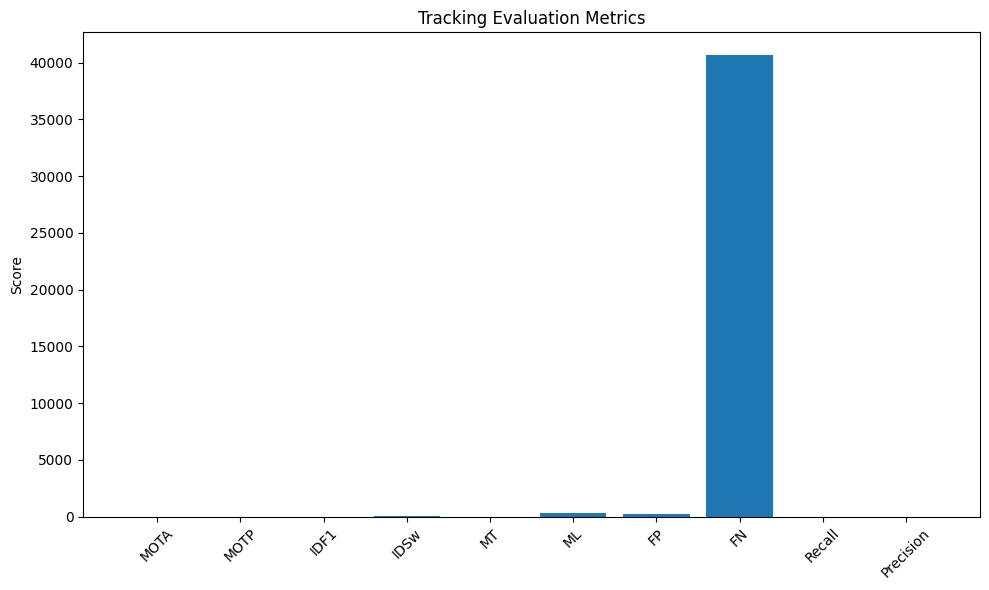

In [61]:
# Quick evaluation directly in notebook
gt_file = "/kaggle/input/cv-multiobject-dectection-dataset/VisDrone2019-MOT-test-dev/VisDrone2019-MOT-test-dev/annotations/uav0000120_04775_v.txt"
result_file = "/kaggle/working/tracking_outputs/uav0000120_04775_v_mot.txt"

evaluator = MOTEvaluator(gt_file, result_file, iou_threshold=0.5)
metrics = evaluator.evaluate()
evaluator.print_metrics()
evaluator.plot_metrics()